<a href="https://colab.research.google.com/github/zsombor-haasz/computer-vision/blob/main/HW2_(SOLN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

## Introduction to Computer Vision

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [ ]:
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from tqdm.notebook import tqdm

### Part 1: Loading the Data

`torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

In [ ]:
batch_size = 16
data_root = './data/cifar10'
transform = transforms.Compose([
    transforms.ToTensor(),
    # scales pixel values to range [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_size = 40_000
val_size = 10_000

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
test_set = torchvision.datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform,
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


Let's check out a few elements of our training set, to make sure that everything is as expected.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

showing training images


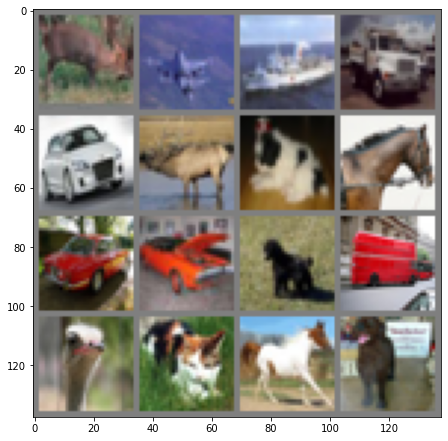

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. Let's try implmenting one.

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future ues
        layer_dims: list of integers, representing the width
            of each of the layers of our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        '''
        ## YOUR CODE HERE
        ## TODO: Remember your call to super!
        super(FCNN, self).__init__()
        ## TODO: Create some linear layers you can use in foward
        ## You may either hard-code that there will be 3 layers,
        ## or you can look into torch.nn.ModuleList()
        self.layers = nn.ModuleList()
        for i in range(len(layer_dims) - 1):
            self.layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
        ## END YOUR CODE

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Flatten the images; remeber that x has a whole batch!
        x = torch.flatten(x, 1)
        ## TODO: Apply each of the layers and relu after each one
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x
        ## END YOUR CODE

NameError: ignored

It will be useful for this part and the later parts to just write general purpose functions to train our model and get the validation scores while training.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, val_loader):
    total_correct = 0
    model = model.to(device)
    for inputs, labels in tqdm(val_loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.argmax(1)
        correct = (outputs == labels)
        total_correct += correct.sum()
    return total_correct / len(val_loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    print('beginning to train model')
    model = model.to(device)
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss
        end_time = time.perf_counter()
        duration = end_time - start_time
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  0	loss: 4369.680	time: 17.272	train acc: 0.4511	val acc: 0.4309


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  1	loss: 3868.486	time: 16.684	train acc: 0.4890	val acc: 0.4649


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  2	loss: 3654.383	time: 14.762	train acc: 0.5232	val acc: 0.4856


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  3	loss: 3494.781	time: 15.022	train acc: 0.5365	val acc: 0.4874


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  4	loss: 3366.272	time: 15.738	train acc: 0.5602	val acc: 0.5037


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  5	loss: 3254.006	time: 14.703	train acc: 0.5701	val acc: 0.4997


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  6	loss: 3161.299	time: 14.745	train acc: 0.5849	val acc: 0.5033


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  7	loss: 3078.119	time: 15.017	train acc: 0.6004	val acc: 0.5110


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  8	loss: 2998.026	time: 14.949	train acc: 0.6051	val acc: 0.5031


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  9	loss: 2924.632	time: 15.195	train acc: 0.6175	val acc: 0.5063


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 10	loss: 2858.994	time: 14.868	train acc: 0.6314	val acc: 0.5104


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 11	loss: 2795.218	time: 14.775	train acc: 0.6458	val acc: 0.5132


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 12	loss: 2733.863	time: 14.913	train acc: 0.6417	val acc: 0.5094


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 13	loss: 2680.680	time: 14.995	train acc: 0.6583	val acc: 0.5143


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 14	loss: 2624.859	time: 15.951	train acc: 0.6652	val acc: 0.5137


As a final observation, let's print the number of parameters that this network learned.

In [ ]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

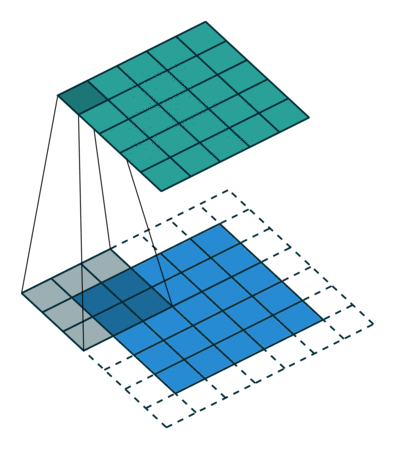

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future ues.

        Please use the following network structure:
        - conv layer with 5 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - conv layer with 16 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - linear (fully-connected) layer with 120 output dims
        - linear (fully-connected) layer with 84 output dims
        - linear (fully-connected) layer with 10 output dims

        After any convolutional or linear layer EXCEPT for the final output,
        we will use a relu activation.
        '''
        ## YOUR CODE HERE
        super(CNN, self).__init__()
        ## TODO: Define your layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ## END YOUR CODE

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images. Refer to the docstring
        for the init method for the order in which to call

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Call your convolutional layers, with activation and pooling.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        ## TODO: Flatten your output
        x = torch.flatten(x, 1)
        ## TODO: Call your linear layers, with activation.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        ## TODO: Remember NOT to call activation after final fully connected layer!
        x = self.fc3(x)
        return x
        ## END YOUR CODE

In [ ]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  0	loss: 5333.640	time: 23.875	train acc: 0.3398	val acc: 0.3415


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  1	loss: 4167.096	time: 17.403	train acc: 0.4531	val acc: 0.4442


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  2	loss: 3698.111	time: 17.184	train acc: 0.4934	val acc: 0.4763


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  3	loss: 3425.168	time: 17.660	train acc: 0.5421	val acc: 0.5241


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  4	loss: 3204.314	time: 17.421	train acc: 0.5654	val acc: 0.5443


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  5	loss: 3019.357	time: 17.558	train acc: 0.5936	val acc: 0.5665


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  6	loss: 2851.848	time: 17.686	train acc: 0.6136	val acc: 0.5857


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  7	loss: 2711.396	time: 17.263	train acc: 0.6401	val acc: 0.6005


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  8	loss: 2582.514	time: 17.390	train acc: 0.6601	val acc: 0.6128


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  9	loss: 2463.119	time: 17.395	train acc: 0.6660	val acc: 0.6066


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 10	loss: 2363.668	time: 17.880	train acc: 0.6841	val acc: 0.6185


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 11	loss: 2269.015	time: 17.266	train acc: 0.7061	val acc: 0.6278


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 12	loss: 2182.167	time: 17.644	train acc: 0.6962	val acc: 0.6166


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 13	loss: 2093.052	time: 18.176	train acc: 0.7221	val acc: 0.6255


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch 14	loss: 2024.660	time: 17.604	train acc: 0.7469	val acc: 0.6436


Again, let us check out the number of parameters learned and compare it to the number for the fully-connected network.

In [ ]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 62006
Ratio: 0.201115760111576


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: ResNet

The final network that we're implementing here is here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead and skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model.

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 1x1 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be an no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        ## YOUR CODE HERE
        ## TODO: Initialize the block with a call to super and make your conv and batchnorm layers.
        super(ResNetBlock, self).__init__()
        self.conv1 = self.conv(in_channels,
                          out_channels,
                          kernel_size=3,
                          stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = self.conv(out_channels,
                          out_channels,
                          kernel_size=3,
                          stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        ## TODO: Use some conditional logic when defining your shortcut layer
        ## For a no-op layer, consider creating an empty nn.Sequential()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                self.conv(in_channels,
                     out_channels,
                     kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        ## END YOUR CODE

    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data on this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
        ## YOUR CODE HERE
        ## TODO: Call the first convolution, batchnorm, and activation
        out = F.relu(self.bn1(self.conv1(x)))
        ## TODO: Call the second convolution and batchnorm
        out = self.bn2(self.conv2(out))
        ## TODO: Also call the shortcut layer on the original input
        out += self.shortcut(x)
        ## TODO: Sum the result of the shortcut and the result of the second batchnorm
        ## and apply your activation
        out = F.relu(out)
        return out
        ## END YOUR CODE

class ResNet18(nn.Module):
    def __init__(self):
        num_classes = 10
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_block(out_channels=64, stride=1)
        self.layer2 = self.make_block(out_channels=128, stride=2)
        self.layer3 = self.make_block(out_channels=256, stride=2)
        self.layer4 = self.make_block(out_channels=512, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [ ]:
num_epochs = 10
resnet = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

This model will take a while (~1 hour) to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of 66% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [ ]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  0	loss: 3319.200	time: 62.720	train acc: 0.6717	val acc: 0.6389


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  1	loss: 2031.669	time: 61.972	train acc: 0.7978	val acc: 0.7283


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  2	loss: 1456.579	time: 61.792	train acc: 0.8492	val acc: 0.7562


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  3	loss: 1068.685	time: 61.725	train acc: 0.9022	val acc: 0.7786


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  4	loss: 762.378	time: 61.746	train acc: 0.9280	val acc: 0.7758


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  5	loss: 520.993	time: 61.740	train acc: 0.9429	val acc: 0.7722


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  6	loss: 349.898	time: 61.908	train acc: 0.9630	val acc: 0.7804


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  7	loss: 260.338	time: 61.888	train acc: 0.9737	val acc: 0.7891


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  8	loss: 194.607	time: 61.869	train acc: 0.9824	val acc: 0.7967


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

epoch  9	loss: 160.011	time: 61.961	train acc: 0.9871	val acc: 0.8042


The previous cell will have taken some time, but it's worth it. The validation accuracies that you see should be much higher than what we got for the previous networks.

## Segmentation (Optional)

In this assignment, you will implement a basic semantic segmentation model called the U-Net. Unlike classification, which assigns a label to the entire image, the problem of semantic segmentation is concerned with assigning a label to each individual image pixel. As such, each semantic cateogry (i.e. class) in an image can be highlighted by the pixels belonging to them. Some of the visualizations below will give you a more concrete understanding of what this problem is trying to achieve!

### 1. Initial setup

In [ ]:
# Need to upgrade torchvision to access the Oxford IIIT Pets dataset that we
# will use in this assignment
!pip install torchinfo
!pip install torchvision --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchinfo import summary
torch.cuda.empty_cache()

import os
import random
import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

# This command will give you more information about the type of GPU that your
# notebook is currently using. Generally, the free tier of Google Colab offers
# either T4s or K80s.
!nvidia-smi

It is generally good practice to assign your device type (cpu or gpu/cuda) to some device variable that you can use throughout the notebook. This way, you won't have to worry about hard-coding the actual device type anywhere and you can switch between different devices without virtually making any changes to your code. As you will see later, oftentimes you need to move some tensors onto the GPU for the computationally heavy training process, but also move some of them back to the CPU for, say, plotting or visualizing your results.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on a GPU")
else:
    device = torch.device("cpu")
    print("Running on a CPU")

### 2. Defining the dataset

We will train our model on the [Oxford IIIT Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset which consists of images of different breeds of cats and dogs. This dataset is nice because we are only working with 3 different classes: the actual pet, a boundary highlighting their figure (this special boundary is called a trimap and it is generally not a common feature in other segmentation datasets), and a background class that captures everything not belonging to the first two classes.

In segmentation tasks, each label is a mask whose pixels specify the class of the corresponding pixels in the image. Since there is a one-to-one correspondance between the pixels of an image and its label (as such, both tensors have the same spatial dimensions), we need to be careful when applying `torchvision` transforms, especially when they pertain to changing the structure of said image. For example, both the image and its label must be scaled by the same amount in each direction if a resize transform is applied. Similarly, any crop transform should cut out the same parts of an image-label pair, and any sort of flip/rotation should affect both tensors the same way about the same axis. This can become complicated when dealing with random transformations (i.e. we would need to ensure the same random parameters get applied to both tensors), which is why we will only consider deterministic ones in this assignment: however, it is something to keep in mind for the future. Fortunately, transformations that don't modify an image's structure but only its value (for example, color jittering or inversion, brightness/contrast shifts, blurring, etc) can be freely applied to just the image without any concern about its label since its semantic content will still remain unchanged.



The following transformation is not present in `torchvision.transforms` but we can define it ourselves. It comes from a PyTorch tutorial on [creating custom image datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample

        h, w = image.size
        if h > w:
            new_h, new_w = self.output_size * h / w, self.output_size
        else:
            new_h, new_w = self.output_size, self.output_size * w / h

        new_h, new_w = int(new_h), int(new_w)

        img = TF.resize(image, (new_w, new_h))

        return img

The images in the Oxford Pets dataset come in different sizes. Therefore, we will adapt a transformation scheme that scales and crops each image down to a 64 by 64 square (feel free to play around with this number). This should more or less capture most of the pet's figure while lowering the image resolution at the same time for faster training. This function will take a few seconds to run since it is downloading the dataset from the internet.

In [ ]:
num_classes = 3 # as specified above, there are 3 classes for each pixel
img_dim = 64
trainset = torchvision.datasets.OxfordIIITPet(root="./", download=True, target_types='segmentation',
                                              transform=transforms.Compose([
                                                            Rescale(img_dim),
                                                            transforms.CenterCrop(img_dim),
                                                            transforms.ToTensor()]),
                                              target_transform=transforms.Compose([
                                                            Rescale(img_dim),
                                                            transforms.CenterCrop(img_dim),
                                                            transforms.Lambda(lambda x: torch.from_numpy(np.array(x) - 1).long())]))
testset = torchvision.datasets.OxfordIIITPet(root="./", download=True, target_types='segmentation', split='test',
                                             transform=transforms.Compose([
                                                            Rescale(img_dim),
                                                            transforms.CenterCrop(img_dim),
                                                            transforms.ToTensor()]),
                                             target_transform=transforms.Compose([
                                                            Rescale(img_dim),
                                                            transforms.CenterCrop(img_dim),
                                                            transforms.Lambda(lambda x: torch.from_numpy(np.array(x) - 1).long())]))

Let's look at some random images from the training dataset and plot their labels. Hopefully, this will clear up any lingering questions about what the semantic segmentation task is all about!

In [ ]:
num_samples = 5
img_grid = gs.GridSpec(num_samples, 4, width_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(10, 10))
plt.axis('off')

for idx, i in enumerate(np.random.choice(len(trainset), num_samples)):
    image, label = trainset[i]
    plt.subplot(img_grid[idx, 0]).imshow(image.permute(1, 2, 0))
    plt.subplot(img_grid[idx, 1]).imshow(label.squeeze())
for ax in fig.get_axes():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.show()

### 3. Defining the model

Now comes the most exciting part of the assignment! The U-Net model was first designed for biomedical imaging (highly recommend checking out the original paper [here](https://arxiv.org/pdf/1505.04597.pdf)) but has since expanded beyond to segmentation tasks in other fields too. As you have already seen in the lectures, the U-Net is a fully convolutional network with a contracting encoder that compresses an image down to some low level features, and an upsampling decoder that expands those features into pixel-wise class predictions. The symmetry between the encoder and decoder gives this model architecture its signature U shape, hence its name!

`Insert U-Net Architecture Image`

Another defining feature of the U-Net is the presence of skip connections. During the contracting path, the network inevitably loses some information about its input image as the intermediate activations get downsampled. To counteract this, the model concatenates the upsampled features with the high resolution features from the encoder, and uses this combined information to proceed further.

Fully connected networks can use regular upsampling techniques (like bilinear interpolation) or learned upsampling layers through transposed convolutions. The latter tends to be more expressive, which is why we will use PyTorch's `ConvTranspose2D` for all upsampling operations.

To make the process of creating a giant neural network like this easier for you, we will break down the network into smaller blocks and chain those afterwards using pooling and transposed convolution layers.

In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        '''
        Here is the expected architecture for a single U-Net Block
        1. Convolutional layer with kernel_size = 3 and padding = (1, 1)
        2. ReLU activation
        3. Batchnorm layer
        4. Convolutional layer with kernel_size = 3 and padding = (1, 1)
        5. ReLU activation
        6. Batchnorm layer

        The kernel size and padding are chosen to preserve the spatial dimensions
        across the inputs and outputs to this block. Both convolutional layers
        have the same number of output channels
        '''
        super().__init__()
        # TODO: define all of the necessary layers
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=output_channels,
                               kernel_size=3,
                               padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(num_features=output_channels)
        self.conv2 = nn.Conv2d(in_channels=output_channels,
                               out_channels=output_channels,
                               kernel_size=3,
                               padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(num_features=output_channels)

    def forward(self, x):
        # TODO: perform a forward pass with the layers above
        out = self.bn1(F.relu(self.conv1(x)))
        out = self.bn2(F.relu(self.conv2(out)))
        return out

Now, we will assemble the full U-Net model. We will only ask you to define the different blocks and layers in the U-Net `__init__` constructor since the forward pass has already been implemented for you. We recommend checking it out for hints about how these blocks and layers should be defined!

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        '''
        Here are all the blocks and layers you need to implement:
        1. U-Net block with 3 input channels and 32 output channels
        2. Max pooling
        3. U-Net block with 32 input channels and 64 output channels
        4. Max pooling
        5. U-Net block with 64 input channels and 128 output channels
        6. Max pooling
        7. U-Net block with 128 input channels and 256 output channels
        8. Max pooling
        9. U-Net block with 256 output channels and 512 output channels
        10. Transpose convolution from 512 input channels to 256 output channels
        11. U-Net block with 512 input channels and 256 output channels
        12. Transpose convolution from 256 input channels to 128 output channels
        13. U-Net block with 256 input channels and 128 output channels
        14. Transpose convolution from 128 input channels to 64 output channels
        15. U-Net block with 128 input channels to 64 output channels
        16. Transpose convolution from 64 input channels to 32 output channels
        17. A single convolutional layer from 32 input channels to `num_classes` output channels

        All transpose convolutions should use a kernel_size of 3, stride of 2,
        padding of 1 and output_padding of 1. This will ensure that the spatial
        dimensions of the intermediate activations are doubled after each upsampling
        operation. To learn more, check out the PyTorch documentation for the
        ConvTranspose2D layer.
        '''
        super().__init__()
        self.num_classes = num_classes

        self.block1 = UNetBlock(3, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.block2 = UNetBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.block3 = UNetBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.block4 = UNetBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)

        self.block5 = UNetBlock(256, 512)

        self.upconv1 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1)
        self.block6 = UNetBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.block7 = UNetBlock(256, 128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.block8 = UNetBlock(128, 64)

        self.upconv4 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.block9 = UNetBlock(64, 32)

        self.block10 = nn.Conv2d(32, self.num_classes, 3, 1, 1)

    def forward(self, x):
        '''
        Forward pass of the U-Net model, given an input image x.
        This function should already be implemented for you.
        In the comments to the right, the first column indicates the number of
        channels in the output of the corresponding layer while the second and
        third highlight the spatial dimensions.
        '''
        out1 = self.block1(x)                   # 32,  1,    1

        out2 = self.pool1(out1)                 # 32,  1/2,  1/2
        out2 = self.block2(out2)                # 64,  1/2,  1/2

        out3 = self.pool2(out2)                 # 64,  1/4,  1/4
        out3 = self.block3(out3)                # 128, 1/4,  1/4

        out4 = self.pool3(out3)                 # 128, 1/8,  1/8
        out4 = self.block4(out4)                # 256, 1/8,  1/8

        out5 = self.pool4(out4)                 # 256, 1/16, 1/16
        out5 = self.block5(out5)                # 512, 1/16, 1/16

        out6 = self.upconv1(out5)               # 256, 1/8,  1/8
        out6 = torch.cat([out4, out6], dim=1)   # 512, 1/8,  1/8
        out6 = self.block6(out6)                # 256, 1/8,  1/8

        out7 = self.upconv2(out6)               # 128, 1/4,  1/4
        out7 = torch.cat([out3, out7], dim=1)   # 256, 1/4,  1/4
        out7 = self.block7(out7)                # 128, 1/4,  1/4

        out8 = self.upconv3(out7)               # 64,  1/2,  1/2
        out8 = torch.cat([out2, out8], dim=1)   # 128, 1/2,  1/2
        out8 = self.block8(out8)                # 64,  1/2,  1/2

        out9 = self.upconv4(out8)               # 32,  1,    1
        out9 = torch.cat([out1, out9], dim=1)   # 64,  1,    1
        out9 = self.block9(out9)                # 32,  1,    1

        out = self.block10(out9)                # n_c, 1,    1
        return out

We will use the `summary` method from the `torchinfo` module to get a nice concise summary about the model's parameters and intermediate activation shapes given a specific input size. This method can be helpful for debugging your forward pass!

In [ ]:
u_net = UNet(num_classes).to(device)

summary(u_net, input_size=(16, 3, 64, 64))

### 4. Training the model

We went over the IoU metric (Jaccard Index) as a useful quantity to measure the performance of a segmentation model. In this part of the assignment, you will implement a function to compute the IOU over a single batch and then the entire dataset.

In [ ]:
def iou(outputs, labels):
    '''
    Compute the IOU metric for each sample in a batch

    outputs: batch of outputs from a UNet with shape (batch_size, num_classes, height, width)
    labels: batch of labels with shape (batch_size, height, width)
    returns: mean iou over the entire batch
    '''
    SMOOTH = 1e-6

    # YOUR CODE HERE
    # TODO: Predict the best class for each pixel for all images in the batch
    # Hint: check out the documentation for torch.argmax!
    # Hint: make sure that the labels and outputs have the same shape afterwards
    outputs = torch.argmax(outputs, dim=1).squeeze(1)

    # TODO: Compute the intersection area between the outputs and labels for each image
    # Hint: recall that intersections can be viewed as the logical 'and' operator
    intersection = (outputs & labels).float().sum((-1, -2))
    # TODO: Compute the union area between the outputs and labels for each image
    # Hint: recall that unions can be viewed as the logical 'or' operator
    union = (outputs | labels).float().sum((-1, -2))

    # TODO: Calculate the IoU metric.
    # Add SMOOTH to both the parts of your ratio to avoid 0/0 division
    iou = (intersection + SMOOTH) / (union + SMOOTH)

    return iou.mean()

def mean_iou(dataset, model):
    '''
    Compute the mean IOU for a given model over the given dataset
    '''
    # TODO: Create a dataloader for the given dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    set_iou = []
    # TODO: Loop over batches in the dataloader and add their mean IOU to set_iou
    # Hint: Consider using torch.no_grad() to speed up computation
    # Hint: Don't forget to set the model to eval mode!
    with torch.no_grad():
        model.eval()
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).squeeze()
            predictions = model(images)
            set_iou.append(iou(predictions, labels))

    mean_iou = sum(set_iou) / len(set_iou)
    return mean_iou.item()

Here is a standard PyTorch training loop. Feel free to modify this but you shouldn't need to.

In [ ]:
def training_loop(model, num_epochs, batch_size, trainset, optimizer, scheduler):
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    train_loss = []
    for epoch in range(1, num_epochs + 1):
        batches = tqdm.notebook.tqdm(train_loader, initial=1)
        model.train()
        running_loss = 0
        for images, labels in batches:
            images = images.to(device)
            labels = labels.to(device).squeeze()
            predictions = model(images)
            optimizer.zero_grad()
            loss = F.cross_entropy(predictions, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if scheduler:
            scheduler.step()
        epoch_iou = mean_iou(trainset, model)
        train_loss.append(running_loss / len(train_loader))
        print("Epoch: {0:02d} | Training Loss: {1:.5f} | IOU: {2:.5f}".format(epoch, train_loss[-1], epoch_iou))
    return train_loss

Feel free to play around with the hyperparameters below! For reference, the staff solution starts out with an IOU of ~0.55 after the first epoch and ends at an IOU of ~0.72 after the last epoch. If your IOU values are significantly different (small differences can pertain to just randomness), consider double checking your IOU implementation and model architecture code!

In [ ]:
num_epochs = 15
batch_size = 16
learning_rate = 1e-3

model = UNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_loss = training_loop(model, num_epochs, batch_size, trainset, optimizer, scheduler=scheduler)

### 5. Visualizing the results

Let's consider the performance of the model on the test set by computing its IOU. For reference, the staff solution gets a mean IOU of >0.68.

In [ ]:
mean_iou(testset, model)

Visualize the model's predictions on random samples from the training set. In the plot below, the left column is the image, the middle column is its label and the right column shows the model's prediction.

In [ ]:
num_samples = 10
img_grid = gs.GridSpec(num_samples, 3, width_ratios=[1, 1, 1], wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=(10, 30))

for idx, i in enumerate(np.random.choice(len(trainset), num_samples)):
    image, label = trainset[i]
    image = image.to(device)
    pred = model(image.unsqueeze(dim=0)).squeeze()
    pred = torch.argmax(pred, dim=0).cpu()
    image = image.cpu()
    plt.subplot(img_grid[idx, 0]).imshow(image.permute(1, 2, 0))
    plt.subplot(img_grid[idx, 1]).imshow(label.squeeze())
    plt.subplot(img_grid[idx, 2]).imshow(pred.squeeze())

Now, visualize the model's predictions on random samples from the test set. As before, the left column is the image, the middle column is its label and the right column shows the model's prediction.

In [ ]:
num_samples = 10
img_grid = gs.GridSpec(num_samples, 3, width_ratios=[1, 1, 1], wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=(10, 30))

for idx, i in enumerate(np.random.choice(len(testset), num_samples)):
    image, label = testset[i]
    image = image.to(device)
    pred = model(image.unsqueeze(dim=0)).squeeze()
    pred = torch.argmax(pred, dim=0).cpu()
    image = image.cpu()
    plt.subplot(img_grid[idx, 0]).imshow(image.permute(1, 2, 0))
    plt.subplot(img_grid[idx, 1]).imshow(label.squeeze())
    plt.subplot(img_grid[idx, 2]).imshow(pred.squeeze())